# This is a notebook for examining the output of the gp_lima_tinygp.py script. 

In [14]:
import arviz as az
import numpy as np
import jax.numpy as jnp
import xarray as xr

import os
import matplotlib.pyplot as plt
os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share"; #fixr
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from textwrap import wrap
cm = 1/2.54  # centimeters in inches

from src.helper_functions import unstandardise
from src.helper_functions import grid_coords_to_2d_latlon_coords
from src.helper_functions import build_gp
from src.plotting_functions import pcolormesh_basemapplot
from src.plotting_functions import scatter_basemapplot

In [15]:
#Loading GP inference data 
gp_idata_path = f'/data/notebooks/jupyterlab-biascorrlab/data/Lima2021/AP_Daily_Snowfall_044_GPFit.nc'
gp_idata = az.from_netcdf(gp_idata_path)

## Examining Posterior

In [16]:
gp_idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

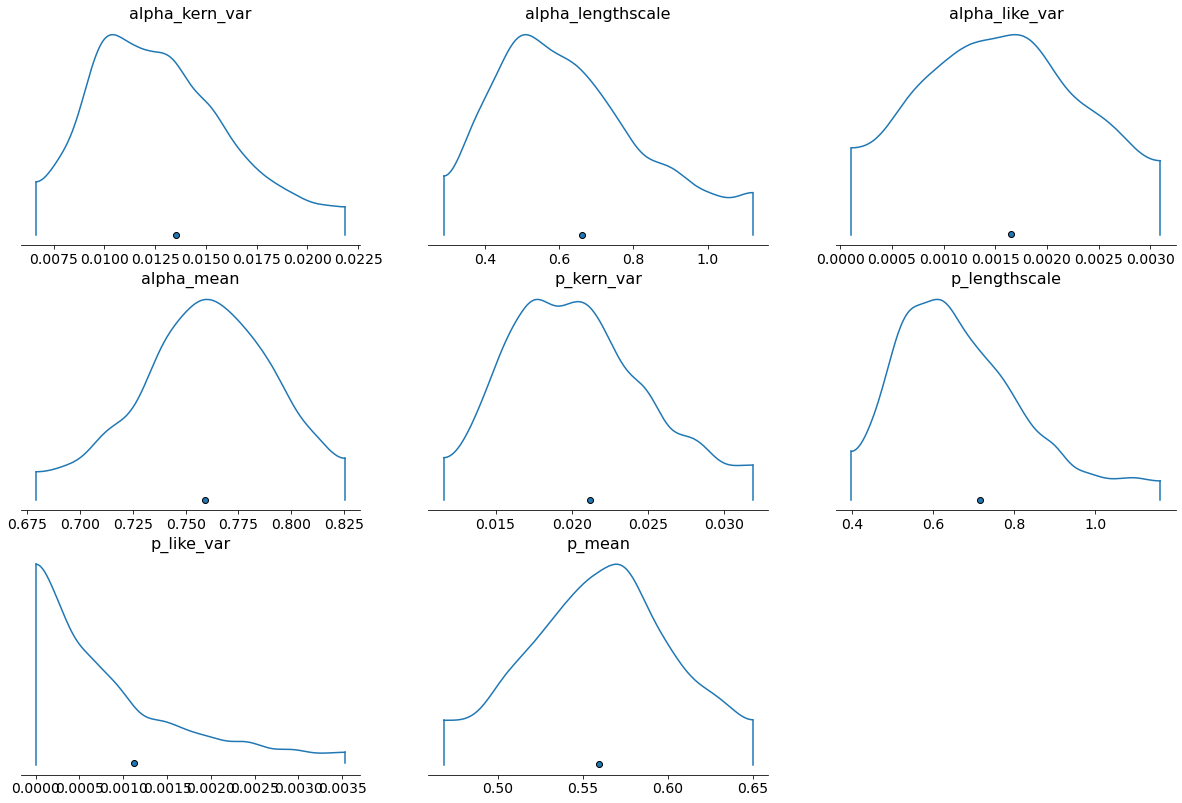

In [20]:
az.plot_density(gp_idata)
plt.show()

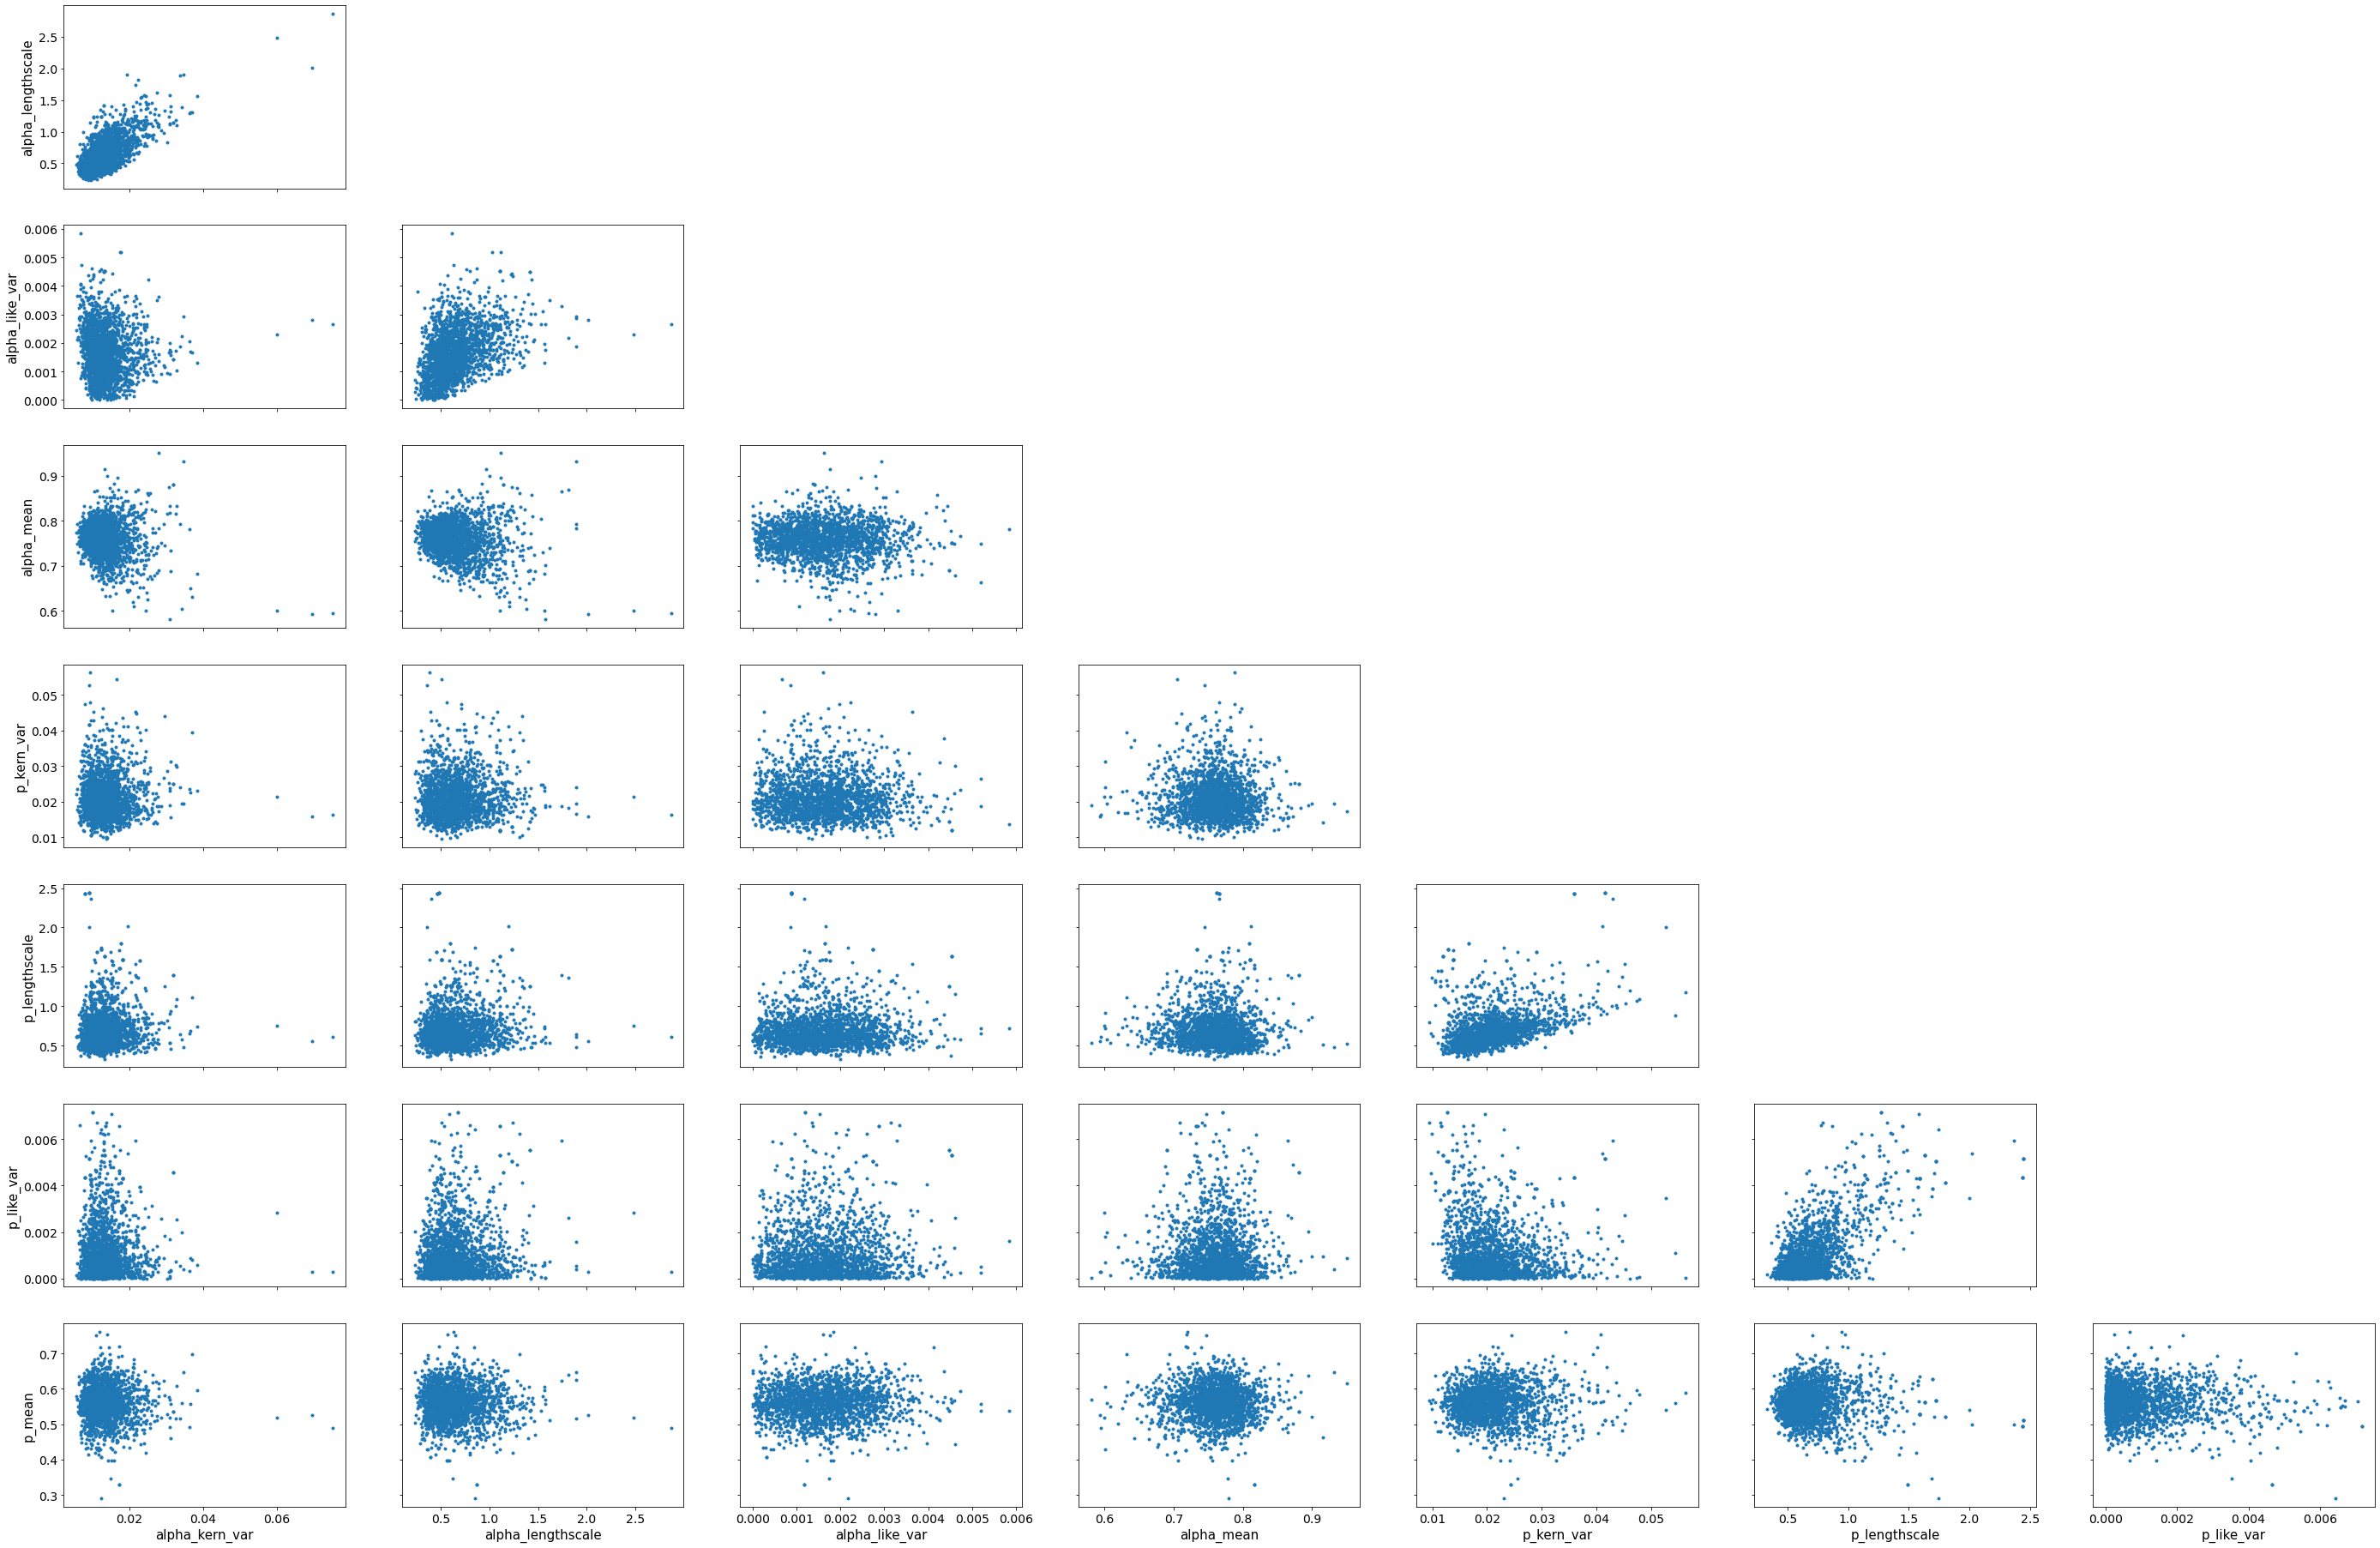

In [22]:
az.plot_pair(gp_idata)
plt.show()

## Conditioning on New Grid (Posterior Predictive)

In [3]:
#Defining new grid to make predictions over 
'''coordinates are in standardised units equivalent to the grid_lat_standardised and grid_lon_standardised coordinates used to fit the GP in gp_lima_tinygp.py'''
x_new = np.arange(-3,3,0.1)
x_new_grid = np.meshgrid(x_new,x_new)
X_new = np.array(x_new_grid).reshape((2,-1)).T

In [4]:
#Constructing the GP objects from the inference data
alpha_gp = build_gp(gp_idata,'alpha')
p_gp = build_gp(gp_idata,'p')
#Conditioning based on observed data and on new coordinates
_, alpha_gpcond = alpha_gp.condition(gp_idata.observed_data['alpha'].data, X_new)
_, p_gpcond = alpha_gp.condition(gp_idata.observed_data['p'].data, X_new)

In [5]:
#Getting the mean and standard deviation of predictions
alpha_mean,alpha_std = alpha_gpcond.mean,np.sqrt(alpha_gpcond.variance)
p_mean,p_std = p_gpcond.mean,np.sqrt(p_gpcond.variance)

In [6]:
#Placing results into xarray dataset
ds = xr.Dataset(
    data_vars=dict(
        alpha=(["grid_latitude","grid_longitude","metric"], np.dstack([alpha_mean.reshape((len(x_new),-1)),alpha_std.reshape((len(x_new),-1))])),
        p=(["grid_latitude","grid_longitude","metric"], np.dstack([p_mean.reshape((len(x_new),-1)),p_std.reshape((len(x_new),-1))])),
    ),
    coords=dict(
        grid_longitude_standardised=("grid_longitude", x_new),
        grid_latitude_standardised=("grid_latitude", x_new),
        grid_longitude=("grid_longitude", unstandardise(newdata = x_new,refdata = gp_idata.observed_data.grid_longitude.data)),
        grid_latitude=("grid_latitude", unstandardise(newdata = x_new,refdata = gp_idata.observed_data.grid_latitude.data)),
        metric=("metric", ['mean','std'])
    ),
)
#Calculating actual Latitude/Longitude values at new locations and appending to dataset
ds = grid_coords_to_2d_latlon_coords(ds,'/data/notebooks/jupyterlab-biascorrlab/data/AP_Daily_Snowfall_044.nc')

### Plotting Mean and Standard Deviation of Predictions against Observations on Standardised Grid

Text(0.5, 1.0, 'Prediction Std (Sigma_Alpha)')

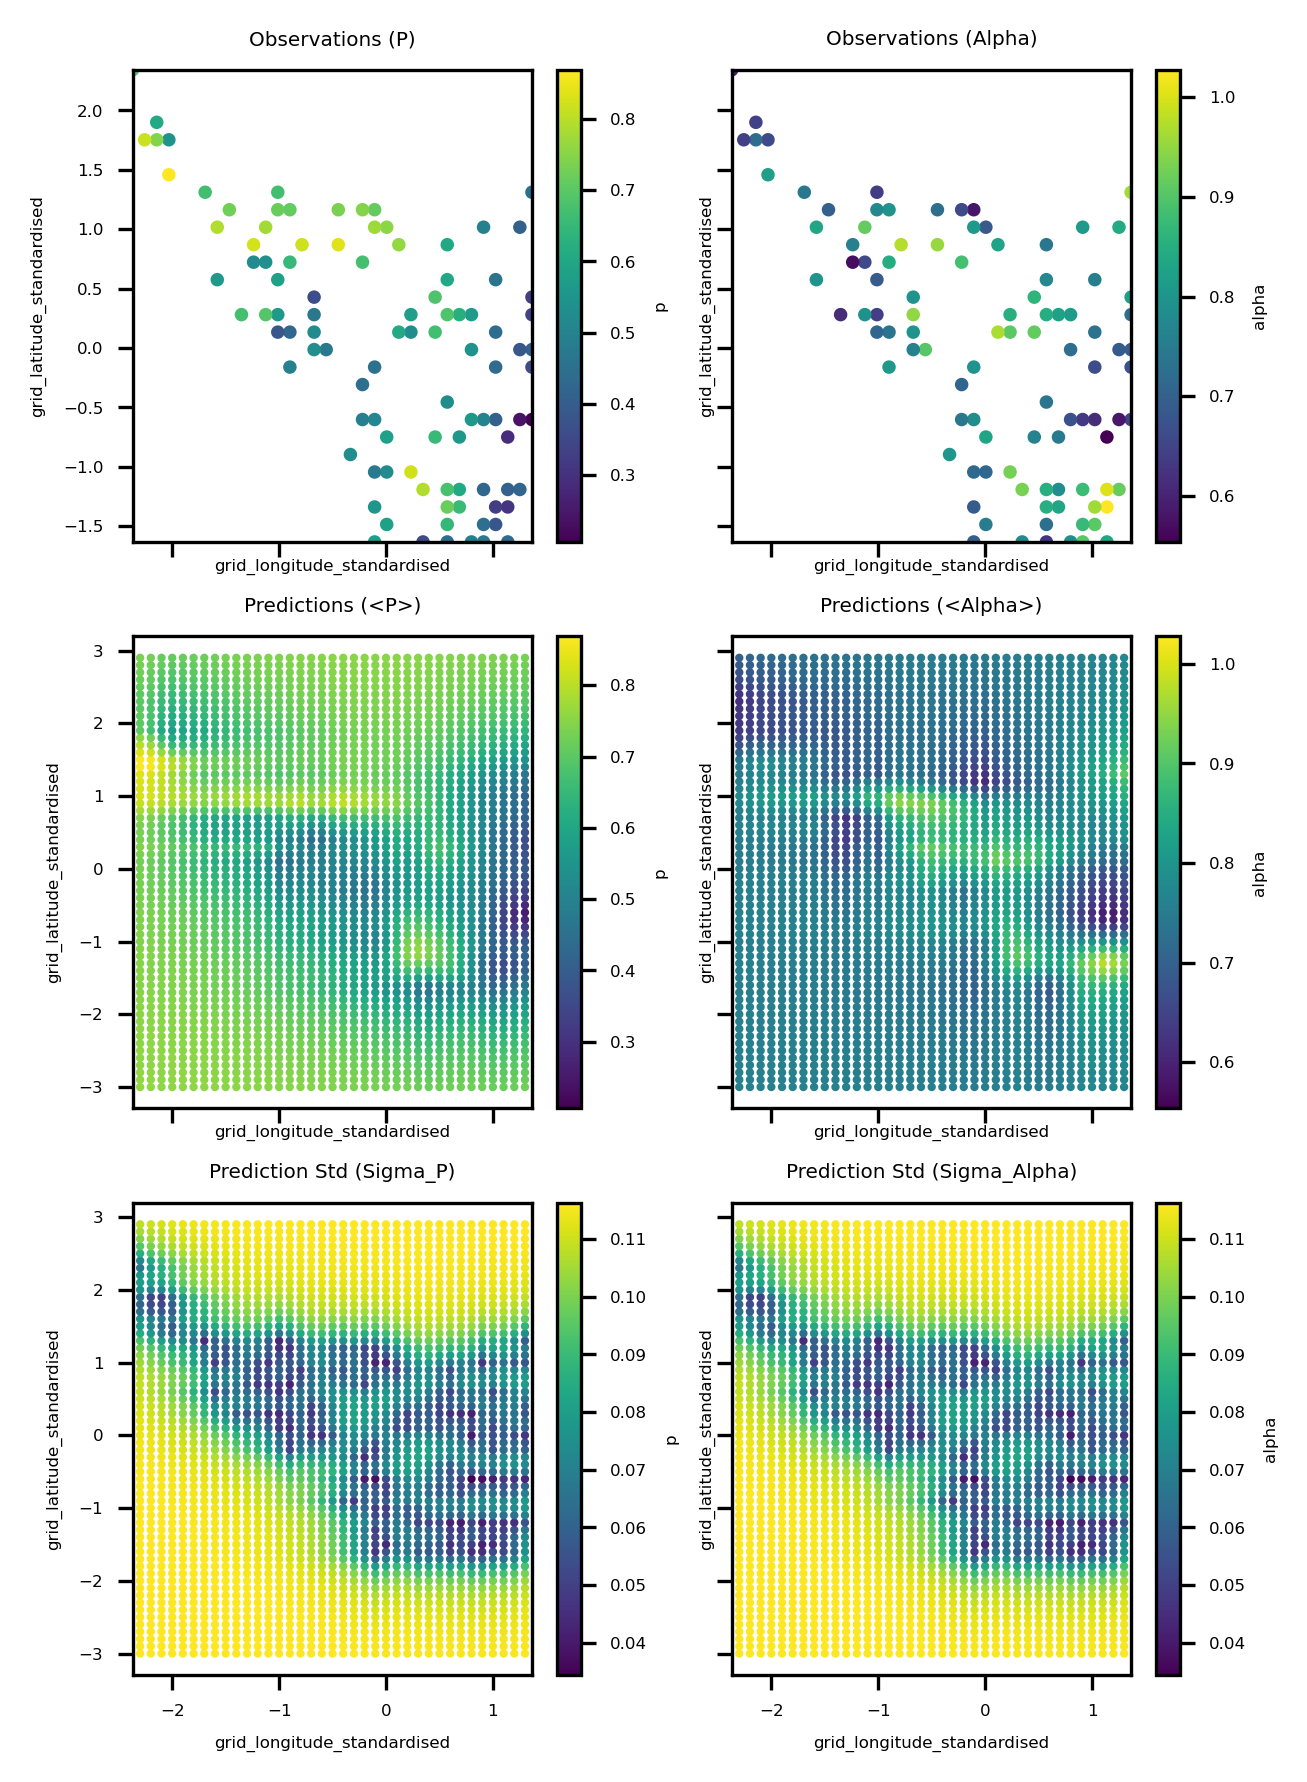

In [7]:
fontsize = 4
plt.rcParams.update({'font.size': fontsize})
min_grid_longitude_standardised,max_grid_longitude_standardised = gp_idata.observed_data.grid_longitude_standardised.min(),gp_idata.observed_data.grid_longitude_standardised.max()
min_grid_latitude_standardised,max_grid_latitude_standardised = gp_idata.observed_data.grid_latitude_standardised.min(),gp_idata.observed_data.grid_latitude_standardised.max()
min_p,max_p = gp_idata.observed_data.p.min(),gp_idata.observed_data.p.max()
min_alpha,max_alpha = gp_idata.observed_data.alpha.min(),gp_idata.observed_data.alpha.max()

fig, axs = plt.subplots(3, 2, sharex='col', sharey='row',figsize=(12*cm, 18.0*cm),dpi= 300,linewidth=0.1)

for ax in axs[0]:
    ax.set_xlim([min_grid_longitude_standardised,max_grid_longitude_standardised])
    ax.set_ylim([min_grid_latitude_standardised,max_grid_latitude_standardised])

plt.subplot(3, 2, 1)
gp_idata.observed_data.plot.scatter(x='grid_longitude_standardised',y='grid_latitude_standardised',hue='p',s=5,vmin=min_p,vmax=max_p)
plt.title('Observations (P)')
plt.subplot(3, 2, 2)
gp_idata.observed_data.plot.scatter(x='grid_longitude_standardised',y='grid_latitude_standardised',hue='alpha',s=5,vmin=min_alpha,vmax=max_alpha)
plt.title('Observations (Alpha)')
plt.subplot(3, 2, 3)
ds.sel(metric='mean').plot.scatter(x='grid_longitude_standardised',y='grid_latitude_standardised',hue='p',s=1,vmin=min_p,vmax=max_p)
plt.title('Predictions (<P>)')
plt.subplot(3, 2, 4)
ds.sel(metric='mean').plot.scatter(x='grid_longitude_standardised',y='grid_latitude_standardised',hue='alpha',s=1,vmin=min_alpha,vmax=max_alpha)
plt.title('Predictions (<Alpha>)')
plt.subplot(3, 2, 5)
ds.sel(metric='std').plot.scatter(x='grid_longitude_standardised',y='grid_latitude_standardised',hue='p',s=1)
plt.title('Prediction Std (Sigma_P)')
plt.subplot(3, 2, 6)
ds.sel(metric='std').plot.scatter(x='grid_longitude_standardised',y='grid_latitude_standardised',hue='alpha',s=1)
plt.title('Prediction Std (Sigma_Alpha)')

### Plotting Mean of Predictions against Observations on Latitude-Longitude Grid with Coastlines Marked

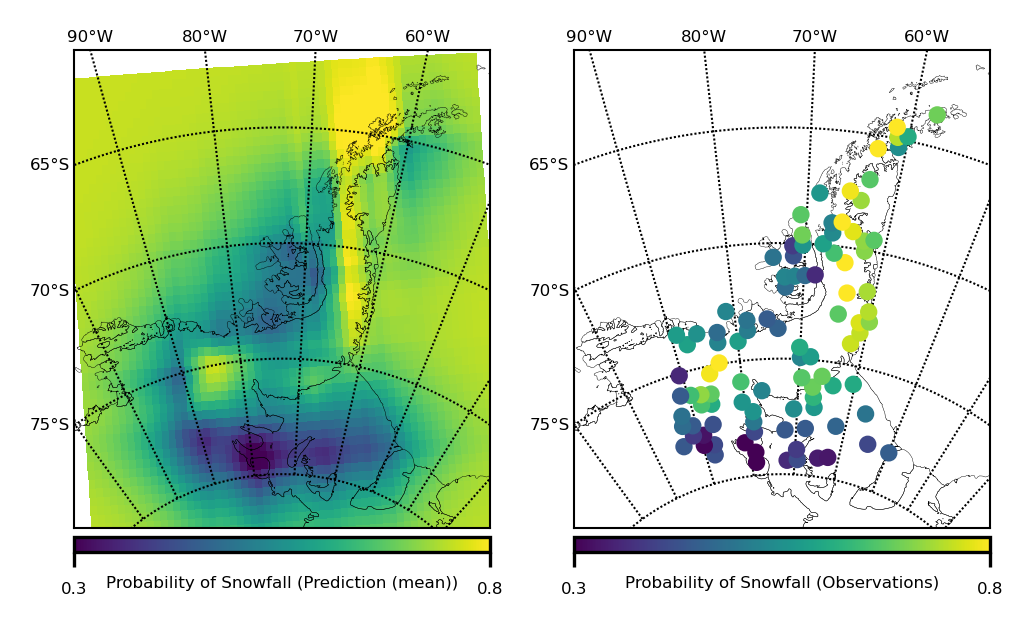

In [8]:
fontsize=4
plt.rcParams.update({'font.size': fontsize})
plots = []
vmin,vmax = 0.3,0.8
variable = 'p'
metric = 'mean'
colorbar_labels = ["\n".join(wrap(f'Probability of Snowfall (Prediction ({metric}))', 100)),"\n".join(wrap('Probability of Snowfall (Observations)', 100))]

antarctica_peninsula_map = Basemap(width=2000000,height=2300000,projection='laea',lat_ts=-30,lat_0=-72,lon_0=-73,resolution='l')
fig, axs = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(10*cm, 6.0*cm),dpi= 300,linewidth=0.1)

plt.subplot(1, 2, 1)
plots.append(pcolormesh_basemapplot(ds,variable,metric,antarctica_peninsula_map,vmin=vmin,vmax=vmax,cmap='viridis',alpha=1))
parallels = np.arange(-90,-60,5)
antarctica_peninsula_map.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5) # labels = [left,right,top,bottom]
meridians = np.arange(-110,-20,10)
antarctica_peninsula_map.drawmeridians(meridians,labels=[False,False,True,False],linewidth=0.5) # labels = [left,right,top,bottom]

plt.subplot(1, 2, 2)
plots.append(scatter_basemapplot(gp_idata.observed_data,variable,antarctica_peninsula_map,vmin,vmax,cmap='viridis',alpha=1))
parallels = np.arange(-90,-60,5)
antarctica_peninsula_map.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5) # labels = [left,right,top,bottom]
meridians = np.arange(-110,-20,10)
antarctica_peninsula_map.drawmeridians(meridians,labels=[False,False,True,False],linewidth=0.5) # labels = [left,right,top,bottom]

for plot,axis,colorbar_label in zip(plots,axs,colorbar_labels):
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('bottom', size='3%', pad=0.03)
    cbar = plt.colorbar(plot,cax=cax,orientation="horizontal")
    cbar.set_ticks([vmin, vmax])
    cbar.ax.set_xticklabels([f'{vmin}', f'{vmax}'],fontsize=fontsize)
    cbar.set_label(colorbar_label,labelpad=-5,fontsize=fontsize)

for axis in axs:
    [x.set_linewidth(0.5) for x in axis.spines.values()]
    
plt.show()

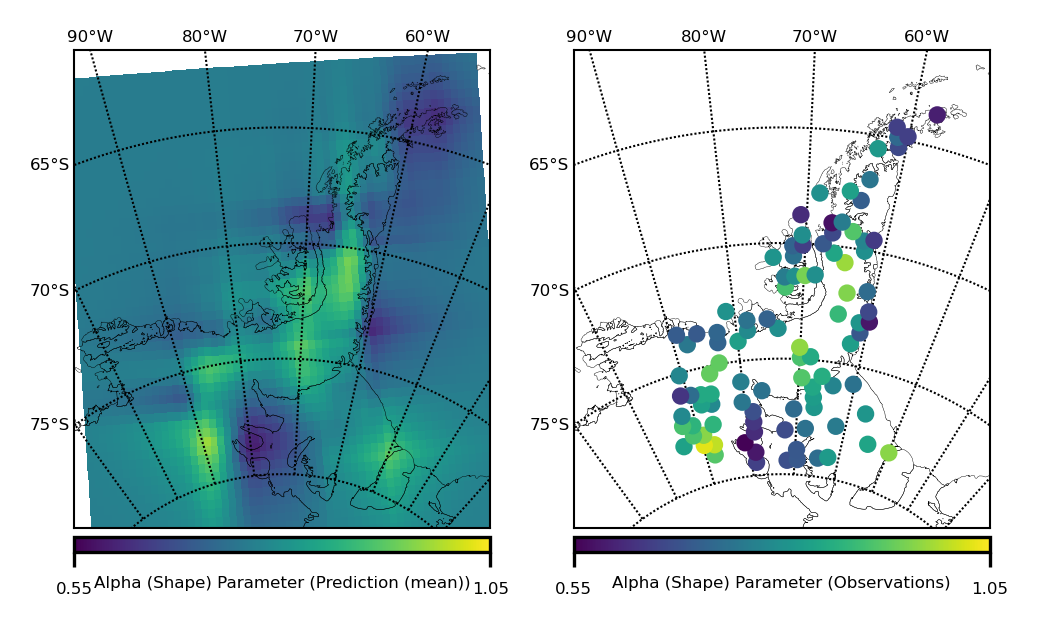

In [9]:
cm = 1/2.54  # centimeters in inches
fontsize=4
plt.rcParams.update({'font.size': fontsize})
plots = []
vmin,vmax = 0.55,1.05
variable = 'alpha'
metric = 'mean'
colorbar_labels = ["\n".join(wrap(f'Alpha (Shape) Parameter (Prediction ({metric}))', 100)),"\n".join(wrap('Alpha (Shape) Parameter (Observations)', 100))]

antarctica_peninsula_map = Basemap(width=2000000,height=2300000,projection='laea',lat_ts=-30,lat_0=-72,lon_0=-73,resolution='l')
fig, axs = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(10*cm, 6.0*cm),dpi= 300,linewidth=0.1)

plt.subplot(1, 2, 1)
plots.append(pcolormesh_basemapplot(ds,variable,metric,antarctica_peninsula_map,vmin=vmin,vmax=vmax,cmap='viridis',alpha=1))
parallels = np.arange(-90,-60,5)
antarctica_peninsula_map.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5) # labels = [left,right,top,bottom]
meridians = np.arange(-110,-20,10)
antarctica_peninsula_map.drawmeridians(meridians,labels=[False,False,True,False],linewidth=0.5) # labels = [left,right,top,bottom]

plt.subplot(1, 2, 2)
plots.append(scatter_basemapplot(gp_idata.observed_data,variable,antarctica_peninsula_map,vmin,vmax,cmap='viridis',alpha=1))
parallels = np.arange(-90,-60,5)
antarctica_peninsula_map.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5) # labels = [left,right,top,bottom]
meridians = np.arange(-110,-20,10)
antarctica_peninsula_map.drawmeridians(meridians,labels=[False,False,True,False],linewidth=0.5) # labels = [left,right,top,bottom]

for plot,axis,colorbar_label in zip(plots,axs,colorbar_labels):
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('bottom', size='3%', pad=0.03)
    cbar = plt.colorbar(plot,cax=cax,orientation="horizontal")
    cbar.set_ticks([vmin, vmax])
    cbar.ax.set_xticklabels([f'{vmin}', f'{vmax}'],fontsize=fontsize)
    cbar.set_label(colorbar_label,labelpad=-5,fontsize=fontsize)

for axis in axs:
    [x.set_linewidth(0.5) for x in axis.spines.values()]
    
plt.show()